In [1]:
import uproot
import numpy as np
import pandas as pd

In [13]:
input_file = "/Users/ploskon/devel/jewel_project/eventfiles/PbPb_lund_200GeV.root"
input_file = "/Users/ploskon/devel/jewel_project/eventfiles/pp_lund_200GeV.root"

In [14]:
df_events = uproot.open(input_file)["event_info"].arrays(library="pd")
df_tracks = uproot.open(input_file)["tracks"].arrays(library="pd")

In [15]:
df_events.head()

,eventID,weight,xsec
0,0.0,5.171740e-13,60.650501
1,1.0,8.328470e-14,273.761993
2,2.0,7.269460e-13,500.895996
3,3.0,7.284760e-13,539.971985
4,4.0,3.802840e-13,585.228027


In [16]:
df_tracks.head()

,eventID,label,px,py,pz,energy
0,0.0,211.0,0.082167,0.391140,-66.613800,66.615196
1,0.0,-321.0,0.344039,0.194148,0.008701,0.632276
2,0.0,321.0,0.074213,-0.052943,-0.275184,0.572431
3,0.0,211.0,-0.789292,0.040457,-0.341560,0.872216
4,0.0,-211.0,-0.182682,-0.156226,-0.886417,0.928975


In [17]:
import yasp

import heppyy.util.fastjet_cppyy
import heppyy.util.pythia8_cppyy
import heppyy.util.heppyy_cppyy

from cppyy.gbl import fastjet as fj
from cppyy.gbl.std import vector

from yasp import GenericObject
import math

# make a singleton class for JetAlgoHelper
class JetAlgoHelper(object):
	_instance = None

	@staticmethod
	def get_instance():
		if JetAlgoHelper._instance is None:
			JetAlgoHelper()
		return JetAlgoHelper._instance

	def __init__(self):
		if JetAlgoHelper._instance is not None:
			raise Exception("This class is a singleton!")
		else:
			JetAlgoHelper._instance = self
			self.jet_def_wta = fj.JetDefinition(fj.cambridge_algorithm, 1.0)
			self.jet_def_wta.set_recombination_scheme(fj.WTA_pt_scheme)
			self.reclusterer_wta 	= fj.contrib.Recluster(self.jet_def_wta)
			self.sd01 = fj.contrib.SoftDrop(0, 0.1, 1.0)
			self.sd02 = fj.contrib.SoftDrop(0, 0.2, 1.0)
			self.lund_gen = fj.contrib.LundGenerator()
			print('[i] creating LundGenerator:', self.lund_gen)

	@classmethod
	def angularity(self, jet, a, k, jetR):
		ang = 0.0
		for p in jet.constituents():
			dr = jet.delta_R(p) / jetR
			pt = p.perp() / jet.perp()
			ang += ((dr)**a) * ((pt)**k)
		return ang

	def mass(self, jet):
		m2 = jet.e()**2 - jet.px()**2 - jet.py()**2 - jet.pz()**2
		if m2 > 0:
			return math.sqrt(m2)
		return 0.0

	def lund_delta_kt(self, jet):
		return [[l.Delta(), l.kt()] for l in self.lund_gen.result(jet)]

	def lund_log(self, jet):
		return [[math.log(1./l.Delta()), math.log(l.kt())] for l in self.lund_gen.result(jet)]

	def lunds_dict_list(self, jet):
		lunds = []
		for i, l in enumerate(self.lund_gen.result(jet)):
			lunds.append({'i': i, 'pt': l.pair().perp(), 
                 		'pt1': l.harder().perp(), 'pt2': l.softer().perp(), 'eta': l.pair().eta(), 
                   	'kt': l.kt(), 'delta': l.Delta(), 'kappa': l.kappa(), 'psi': l.psi(), 'z': l.z(), 'm': l.m()})
		return lunds

class LundJet(GenericObject):
	def __init__(self, jet, jetR, label=None, **kwargs):
		super().__init__(**kwargs)
		self.jet = jet
		self.pt = jet.pt()
		self.eta = jet.eta()
		self.y = jet.rap()
		self.phi = jet.phi()
		self.e = jet.e()
		self.m = jet.m()
		self.nconst = jet.constituents().size()
		self.jetR = jetR
		self.label = label

		self._jalgo = JetAlgoHelper.get_instance()

		self.jet_wta 	= self._jalgo.reclusterer_wta.result(jet)
		self.jet_sd01 = self._jalgo.sd01.result(jet)
		self.jet_sd02 = self._jalgo.sd02.result(jet)
		self.wtastd 	= self.jet_wta.delta_R(jet)
		self.wtasd01 	= self.jet_sd01.delta_R(jet)
		self.wtasd02 	= self.jet_sd02.delta_R(jet)
		self.angk1a1 	= self._jalgo.angularity(jet, 1.0, 1.0, self.jetR)
		self.angk1a2 	= self._jalgo.angularity(jet, 2.0, 1.0, self.jetR)
		self.angk1a3 	= self._jalgo.angularity(jet, 3.0, 1.0, self.jetR)
		self.mjet 		= self._jalgo.mass(jet)
		# self.lund_delta_kt = self._jalgo.lund_delta_kt(jet)
		# self.lund_log = self._jalgo.lund_log(jet)
		self.lunds = self._jalgo.lunds_dict_list(jet)

		self._base_props_list = []
		self._base_props_list = self._gen_base_props_list()

	def _gen_base_props_list(self):
		_g0 = GenericObject()
		l = [a for a in _g0.__dict__]
		_ = [l.append(a) for a in self.__dict__ if a[0] == '_' and a not in l]
		return l

	def to_dict(self):
		# Convert the object to a dictionary
		d = {}
		for key in self.__dict__:
			if key not in self._base_props_list:
				d[key] = getattr(self, key)
		return d

	def to_basic_type_dict(self):
		# Convert the object to a dictionary
		d = {}
		for key in self.__dict__:
			if key not in self._base_props_list:
				o = getattr(self, key)
				if isinstance(o, fj.PseudoJet):
					d[key] = [o.px(), o.py(), o.pz(), o.e()]
				else:
					d[key] = getattr(self, key)
		return d

In [18]:
def lund_jets(df, include_groups=True, label=''):
  jets_dicts = []
  parts = vector[fj.PseudoJet]([fj.PseudoJet(p.px, p.py, p.pz, p.energy) for p in df.itertuples()])
  jet_def = fj.JetDefinition(fj.antikt_algorithm, 0.4)
  cluster_seq = fj.ClusterSequence(parts, jet_def)
  jets = fj.sorted_by_pt(cluster_seq.inclusive_jets())
  
  for j in jets:
    jet = LundJet(jet=j, jetR=0.4, label=label)
    jets_dicts.append(jet.to_basic_type_dict())
  
  return pd.DataFrame(jets_dicts)

In [19]:
df_lunds = pd.merge(df_events, df_tracks, on="eventID").groupby("eventID").apply(lund_jets, include_groups=False, label='PbPb').reset_index(drop=True)
df_lunds.to_parquet('saved_lunds.parquet', engine="pyarrow")

[i] creating LundGenerator: @0x36a10fa20


In [20]:
!ls -ltr *.parquet

-rw-r--r--@ 1 ploskon  staff      19033 May 14 18:32 jets.parquet
-rw-r--r--@ 1 ploskon  staff   14620522 May 16 19:18 pythia_lund_jet_unlabelled.parquet
-rw-r--r--@ 1 ploskon  staff   15039365 May 19 14:22 lund_jet_hardQCDbeauty.parquet
-rw-r--r--@ 1 ploskon  staff   14961016 May 19 14:22 lund_jet_hardQCDcharm.parquet
-rw-r--r--@ 1 ploskon  staff   14231883 May 19 14:23 lund_jet_hardQCDquarks.parquet
-rw-r--r--@ 1 ploskon  staff   14621070 May 19 14:23 lund_jet_hardQCDany.parquet
-rw-r--r--@ 1 ploskon  staff   14711110 May 19 14:23 lund_jet_hardQCDlf.parquet
-rw-r--r--@ 1 ploskon  staff   14815345 May 19 14:23 lund_jet_hardQCDgluons.parquet
-rw-r--r--@ 1 ploskon  staff      28018 May 20 16:16 pythia_lund_jet.parquet
-rw-r--r--@ 1 ploskon  staff      29788 May 20 16:16 pythia_lund_jet_emb.parquet
-rw-r--r--@ 1 ploskon  staff  180554974 Jul 24 11:38 saved_lunds.parquet


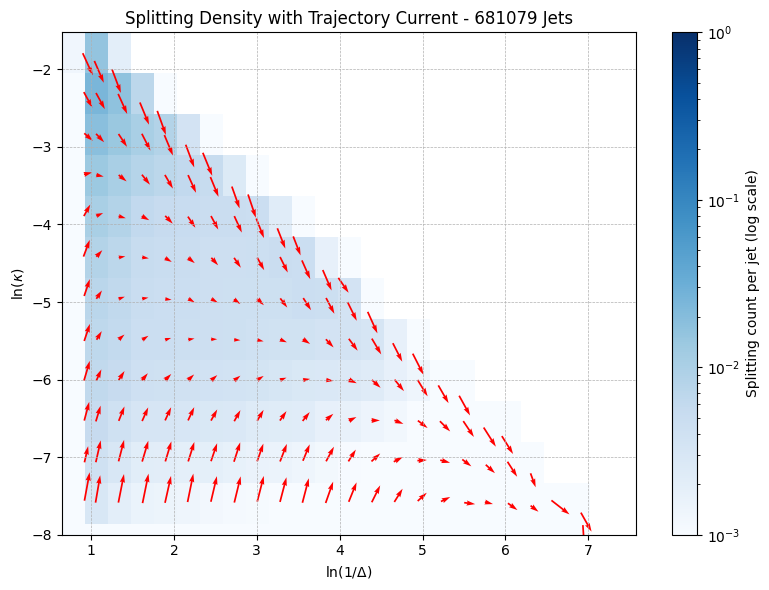

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Load your parquet file
df_jets = pd.read_parquet('saved_lunds.parquet')

s_kt_or_kappa = 'kt'
s_kt_or_kappa = 'kappa'

# Extract lund records from all jets
records = []
for _, row in df_jets.iterrows():
    lunds = row['lunds']
    for i in range(len(lunds) - 1):
        kt_i, delta_i = lunds[i][s_kt_or_kappa], lunds[i]['delta']
        kt_j, delta_j = lunds[i+1][s_kt_or_kappa], lunds[i+1]['delta']
        x_i, y_i = np.log(1/delta_i), np.log(kt_i)
        x_j, y_j = np.log(1/delta_j), np.log(kt_j)
        records.append({'x': x_i, 'y': y_i, 'dx': x_j - x_i, 'dy': y_j - y_i})

df = pd.DataFrame(records)

# Define grid and bin the (x,y) positions
nx, ny = 25, 25
x_bins = np.linspace(df['x'].min(), df['x'].max(), nx + 1)
y_bins = np.linspace(df['y'].min(), df['y'].max(), ny + 1)
df['ix'] = pd.cut(df['x'], bins=x_bins, labels=False, include_lowest=True)
df['iy'] = pd.cut(df['y'], bins=y_bins, labels=False, include_lowest=True)

# Compute average displacement per bin
group = (
    df.groupby(['ix', 'iy'])
      .agg(x=('x', 'mean'), y=('y', 'mean'),
           dx=('dx', 'mean'), dy=('dy', 'mean'))
      .dropna()
      .reset_index()
)

y_limit_low = df['y'].min()
y_limit_low = -8
if s_kt_or_kappa == 'kt':
    # Apply cut for plotting only (ln(kT) > -4)
    y_limit_low = -4

df_plot = df[df['y'] > y_limit_low]
group_plot = group[group['y'] > y_limit_low]

plt.figure(figsize=(8, 6))

# 1) density background (only for ln(kT) > -4)
weights_plot = np.ones_like(df_plot['x']) / len(df_jets)
plt.hist2d(
    df_plot['x'], df_plot['y'],
    bins=[x_bins, y_bins],
    cmap='Blues',
    norm=mcolors.LogNorm(),
    weights=weights_plot
)
plt.clim(0.001, 1.0)
plt.colorbar(label='Splitting count per jet (log scale)')

# 2) trajectory current (quiver only for arrows starting at ln(kT) > -4)
plt.quiver(group_plot['x'], group_plot['y'], group_plot['dx'], group_plot['dy'], 
           angles='xy', scale_units='xy', scale=5, width=0.003, color='red', alpha=1.0)

plt.xlabel(r'$\ln(1/\Delta)$')
ylabel_latex = r'$\ln(k_T)$' if s_kt_or_kappa == 'kt' else r'$\ln(\kappa)$'
plt.ylabel(ylabel_latex)
plt.ylim(y_limit_low, None)
plt.title(f'Splitting Density with Trajectory Current - {len(df_jets)} Jets')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

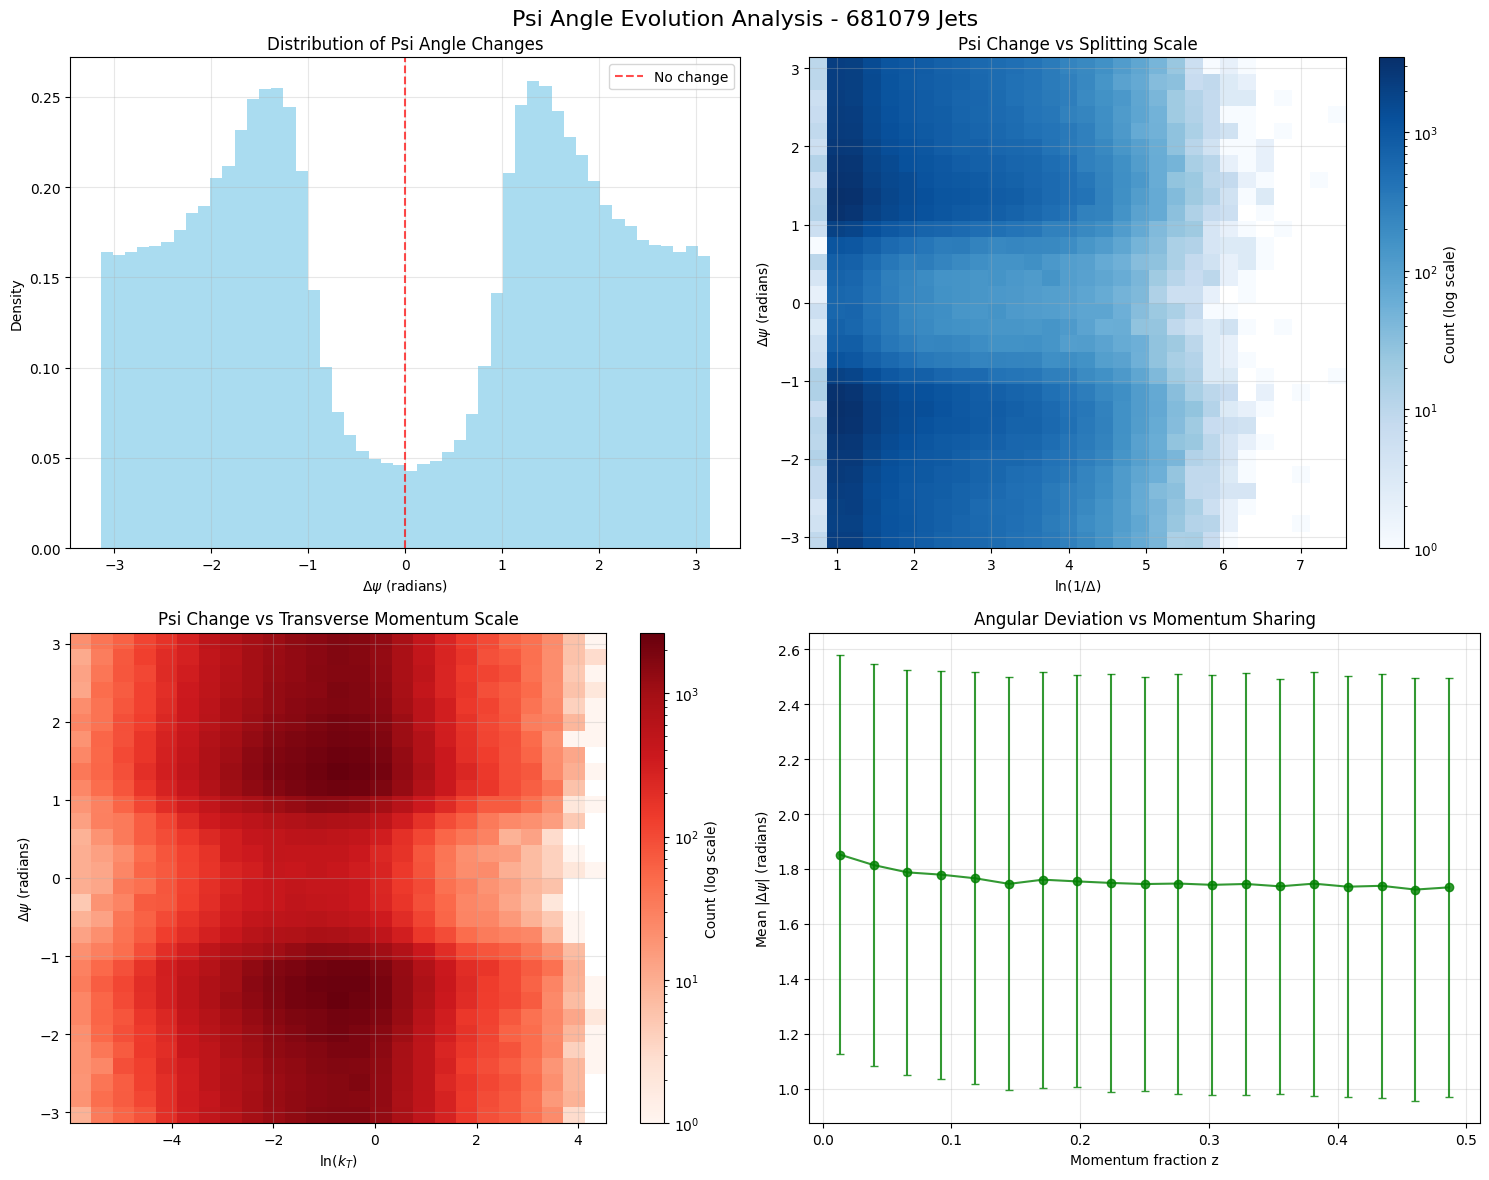

Total number of consecutive splitting pairs: 388922
Mean |Δψ|: 1.785 radians
Std |Δψ|: 0.747 radians
Fraction with |Δψ| > π/2: 0.582
Fraction with |Δψ| > π/4: 0.912


In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Load your parquet file
df_jets = pd.read_parquet('saved_lunds.parquet')

# Extract psi angle changes from all jets
psi_records = []
for jet_idx, row in df_jets.iterrows():
    lunds = row['lunds']
    if len(lunds) < 2:  # Need at least 2 splittings
        continue
    
    for i in range(len(lunds) - 1):
        psi_i = lunds[i]['psi']
        psi_j = lunds[i+1]['psi']
        
        # Calculate psi change, handling periodicity (-pi to pi)
        delta_psi = psi_j - psi_i
        # Wrap to [-pi, pi]
        while delta_psi > np.pi:
            delta_psi -= 2*np.pi
        while delta_psi < -np.pi:
            delta_psi += 2*np.pi
            
        # Also get other splitting properties for context
        kt_i = lunds[i]['kt']
        delta_i = lunds[i]['delta']
        z_i = lunds[i]['z']
        
        psi_records.append({
            'jet_idx': jet_idx,
            'splitting_idx': i,
            'psi_i': psi_i,
            'psi_j': psi_j,
            'delta_psi': delta_psi,
            'ln_kt': np.log(kt_i),
            'ln_inv_delta': np.log(1/delta_i),
            'z': z_i
        })

df_psi = pd.DataFrame(psi_records)

# Create a comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1) Distribution of psi angle changes
ax1 = axes[0, 0]
ax1.hist(df_psi['delta_psi'], bins=50, alpha=0.7, color='skyblue', density=True)
ax1.axvline(0, color='red', linestyle='--', alpha=0.7, label='No change')
ax1.set_xlabel(r'$\Delta\psi$ (radians)')
ax1.set_ylabel('Density')
ax1.set_title('Distribution of Psi Angle Changes')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2) Psi change vs ln(1/Delta) - shows angular evolution vs splitting scale
ax2 = axes[0, 1]
# Create 2D histogram for better visualization of dense data
h = ax2.hist2d(df_psi['ln_inv_delta'], df_psi['delta_psi'], 
               bins=[30, 30], cmap='Blues', norm=mcolors.LogNorm())
plt.colorbar(h[3], ax=ax2, label='Count (log scale)')
ax2.set_xlabel(r'$\ln(1/\Delta)$')
ax2.set_ylabel(r'$\Delta\psi$ (radians)')
ax2.set_title('Psi Change vs Splitting Scale')
ax2.grid(True, alpha=0.3)

# 3) Psi change vs ln(kT) - shows angular evolution vs transverse momentum scale
ax3 = axes[1, 0]
# Filter for reasonable kT range to avoid clutter
df_psi_filtered = df_psi[df_psi['ln_kt'] > -6]
h = ax3.hist2d(df_psi_filtered['ln_kt'], df_psi_filtered['delta_psi'], 
               bins=[25, 30], cmap='Reds', norm=mcolors.LogNorm())
plt.colorbar(h[3], ax=ax3, label='Count (log scale)')
ax3.set_xlabel(r'$\ln(k_T)$')
ax3.set_ylabel(r'$\Delta\psi$ (radians)')
ax3.set_title('Psi Change vs Transverse Momentum Scale')
ax3.grid(True, alpha=0.3)

# 4) Psi change vs momentum fraction z
ax4 = axes[1, 1]
# Create bins for z and calculate mean delta_psi in each bin
z_bins = np.linspace(0, 0.5, 20)  # Focus on z < 0.5 (softer splittings)
df_psi_z = df_psi[df_psi['z'] < 0.5]
z_centers = []
delta_psi_means = []
delta_psi_stds = []

for i in range(len(z_bins)-1):
    mask = (df_psi_z['z'] >= z_bins[i]) & (df_psi_z['z'] < z_bins[i+1])
    if mask.sum() > 10:  # Require at least 10 points
        z_centers.append((z_bins[i] + z_bins[i+1]) / 2)
        delta_psi_means.append(df_psi_z[mask]['delta_psi'].abs().mean())
        delta_psi_stds.append(df_psi_z[mask]['delta_psi'].abs().std())

z_centers = np.array(z_centers)
delta_psi_means = np.array(delta_psi_means)
delta_psi_stds = np.array(delta_psi_stds)

ax4.errorbar(z_centers, delta_psi_means, yerr=delta_psi_stds, 
             marker='o', capsize=3, color='green', alpha=0.8)
ax4.set_xlabel('Momentum fraction z')
ax4.set_ylabel(r'Mean $|\Delta\psi|$ (radians)')
ax4.set_title('Angular Deviation vs Momentum Sharing')
ax4.grid(True, alpha=0.3)

plt.suptitle(f'Psi Angle Evolution Analysis - {len(df_jets)} Jets', fontsize=16)
plt.tight_layout()
plt.show()

# Print some statistics
print(f"Total number of consecutive splitting pairs: {len(df_psi)}")
print(f"Mean |Δψ|: {df_psi['delta_psi'].abs().mean():.3f} radians")
print(f"Std |Δψ|: {df_psi['delta_psi'].abs().std():.3f} radians")
print(f"Fraction with |Δψ| > π/2: {(df_psi['delta_psi'].abs() > np.pi/2).mean():.3f}")
print(f"Fraction with |Δψ| > π/4: {(df_psi['delta_psi'].abs() > np.pi/4).mean():.3f}")

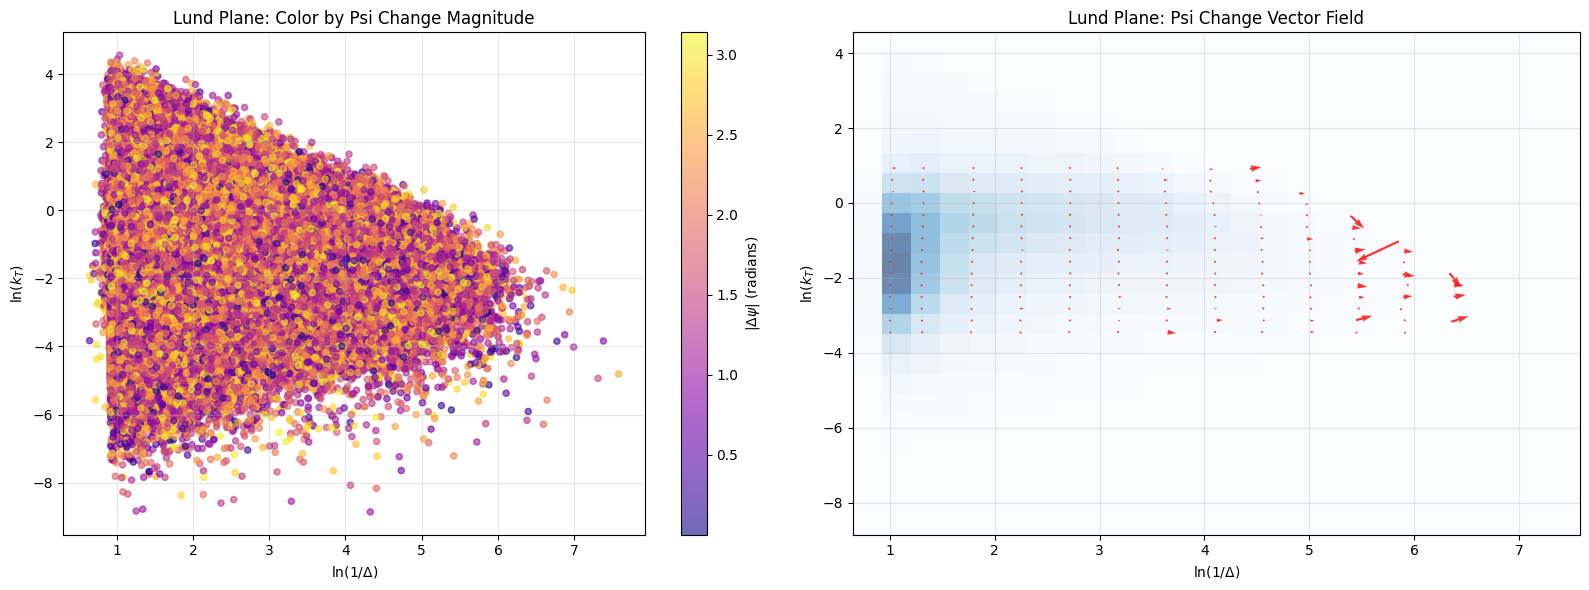


Correlation Analysis:
  |Δψ| vs z: 0.003
  |Δψ| vs ln_inv_delta: 0.001
  |Δψ| vs ln_kt: 0.001

Jet-by-jet psi evolution (first 5 jets):
  Jet 0: ψ = ['-1.47', '2.93', '-2.62', '2.31', '-2.17', '-2.31', '-2.06', '2.21']
            Δψ = ['-1.89', '0.73', '-1.35', '1.80', '-0.14', '0.25', '-2.02']
  Jet 1: ψ = ['0.24', '-0.95', '1.65', '2.87', '-2.53', '0.12', '0.66', '2.96', '-1.78']
            Δψ = ['-1.20', '2.60', '1.23', '0.88', '2.66', '0.54', '2.29', '1.55']
  Jet 2: ψ = ['2.71', '1.41', '-1.37', '0.12', '-2.84', '-0.52']
            Δψ = ['-1.30', '-2.79', '1.49', '-2.96', '2.32']
  Jet 3: ψ = ['-2.70', '0.84', '2.23', '1.65', '0.44', '-1.07', '-2.91']
            Δψ = ['-2.75', '1.39', '-0.57', '-1.21', '-1.51', '-1.84']
  Jet 4: ψ = ['-0.97', '-1.88', '-0.82', '1.49']
            Δψ = ['-0.91', '1.06', '2.31']


In [23]:
# Psi Angle Trajectories in Lund Plane
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1) Color-coded by psi change magnitude
ax1 = axes[0]
scatter = ax1.scatter(df_psi['ln_inv_delta'], df_psi['ln_kt'], 
                     c=np.abs(df_psi['delta_psi']), 
                     cmap='plasma', s=20, alpha=0.6)
plt.colorbar(scatter, ax=ax1, label=r'$|\Delta\psi|$ (radians)')
ax1.set_xlabel(r'$\ln(1/\Delta)$')
ax1.set_ylabel(r'$\ln(k_T)$')
ax1.set_title('Lund Plane: Color by Psi Change Magnitude')
ax1.grid(True, alpha=0.3)

# 2) Vector field showing psi evolution direction
ax2 = axes[1]

# Create a background density plot first
weights = np.ones_like(df_psi['ln_inv_delta']) / len(df_jets)
ax2.hist2d(df_psi['ln_inv_delta'], df_psi['ln_kt'], 
           bins=[25, 25], cmap='Blues', alpha=0.6, weights=weights)

# Create a vector field based on psi changes
# Bin the data and calculate average psi change direction
nx, ny = 15, 15
x_bins = np.linspace(df_psi['ln_inv_delta'].min(), df_psi['ln_inv_delta'].max(), nx + 1)
y_bins = np.linspace(df_psi['ln_kt'].quantile(0.05), df_psi['ln_kt'].quantile(0.95), ny + 1)

df_psi['ix'] = pd.cut(df_psi['ln_inv_delta'], bins=x_bins, labels=False, include_lowest=True)
df_psi['iy'] = pd.cut(df_psi['ln_kt'], bins=y_bins, labels=False, include_lowest=True)

# Compute average position and psi change per bin
psi_group = (
    df_psi.groupby(['ix', 'iy'])
    .agg(x=('ln_inv_delta', 'mean'), 
         y=('ln_kt', 'mean'),
         delta_psi_mean=('delta_psi', 'mean'),
         delta_psi_std=('delta_psi', 'std'),
         count=('delta_psi', 'count'))
    .dropna()
    .reset_index()
)

# Filter bins with sufficient statistics
psi_group = psi_group[psi_group['count'] >= 5]

# Convert psi change to arrow components (just for visualization direction)
# Scale arrows by the magnitude of average psi change
arrow_scale = 0.3
u = arrow_scale * np.cos(psi_group['delta_psi_mean']) * np.abs(psi_group['delta_psi_mean'])
v = arrow_scale * np.sin(psi_group['delta_psi_mean']) * np.abs(psi_group['delta_psi_mean'])

ax2.quiver(psi_group['x'], psi_group['y'], u, v,
           angles='xy', scale_units='xy', scale=1, 
           width=0.003, color='red', alpha=0.8)

ax2.set_xlabel(r'$\ln(1/\Delta)$')
ax2.set_ylabel(r'$\ln(k_T)$')
ax2.set_title('Lund Plane: Psi Change Vector Field')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Additional analysis: Correlation between psi changes and other variables
print("\nCorrelation Analysis:")
correlations = df_psi[['delta_psi', 'ln_kt', 'ln_inv_delta', 'z']].corr()['delta_psi'].abs().sort_values(ascending=False)
for var, corr in correlations.items():
    if var != 'delta_psi':
        print(f"  |Δψ| vs {var}: {corr:.3f}")

# Look at psi evolution patterns within individual jets
print(f"\nJet-by-jet psi evolution (first 5 jets):")
for jet_idx in df_psi['jet_idx'].unique()[:5]:
    jet_data = df_psi[df_psi['jet_idx'] == jet_idx].sort_values('splitting_idx')
    if len(jet_data) >= 2:
        psi_sequence = jet_data['psi_i'].tolist() + [jet_data.iloc[-1]['psi_j']]
        delta_psi_sequence = jet_data['delta_psi'].tolist()
        print(f"  Jet {jet_idx}: ψ = {[f'{p:.2f}' for p in psi_sequence]}")
        print(f"            Δψ = {[f'{dp:.2f}' for dp in delta_psi_sequence]}")

In [24]:
# Analysis: Highest kT splitting and its immediate successor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Load your parquet file
df_jets = pd.read_parquet('saved_lunds.parquet')

# Extract highest kT splitting and next splitting pairs
hardest_pairs = []
for jet_idx, row in df_jets.iterrows():
    lunds = row['lunds']
    if len(lunds) < 2:  # Need at least 2 splittings
        continue
    
    # Find the splitting with highest kT
    kt_values = [l['kt'] for l in lunds]
    max_kt_idx = np.argmax(kt_values)
    
    # Check if there's a next splitting after the hardest one
    if max_kt_idx < len(lunds) - 1:
        hardest = lunds[max_kt_idx]
        next_split = lunds[max_kt_idx + 1]
        
        # Calculate psi change
        delta_psi = next_split['psi'] - hardest['psi']
        # Wrap to [-pi, pi]
        while delta_psi > np.pi:
            delta_psi -= 2*np.pi
        while delta_psi < -np.pi:
            delta_psi += 2*np.pi
        
        hardest_pairs.append({
            'jet_idx': jet_idx,
            'hardest_kt': hardest['kt'],
            'hardest_ln_kt': np.log(hardest['kt']),
            'hardest_ln_inv_delta': np.log(1/hardest['delta']),
            'hardest_z': hardest['z'],
            'hardest_psi': hardest['psi'],
            'next_kt': next_split['kt'],
            'next_ln_kt': np.log(next_split['kt']),
            'next_ln_inv_delta': np.log(1/next_split['delta']),
            'next_z': next_split['z'],
            'next_psi': next_split['psi'],
            'delta_psi': delta_psi,
            'kt_ratio': next_split['kt'] / hardest['kt'],
            'delta_ratio': next_split['delta'] / hardest['delta']
        })

df_hardest = pd.DataFrame(hardest_pairs)

print(f"Number of jets with hardest + next splitting pairs: {len(df_hardest)}")
print(f"Mean kT ratio (next/hardest): {df_hardest['kt_ratio'].mean():.3f}")
print(f"Mean |Δψ| for hardest pairs: {df_hardest['delta_psi'].abs().mean():.3f} radians")

Number of jets with hardest + next splitting pairs: 91477
Mean kT ratio (next/hardest): 0.318
Mean |Δψ| for hardest pairs: 1.760 radians


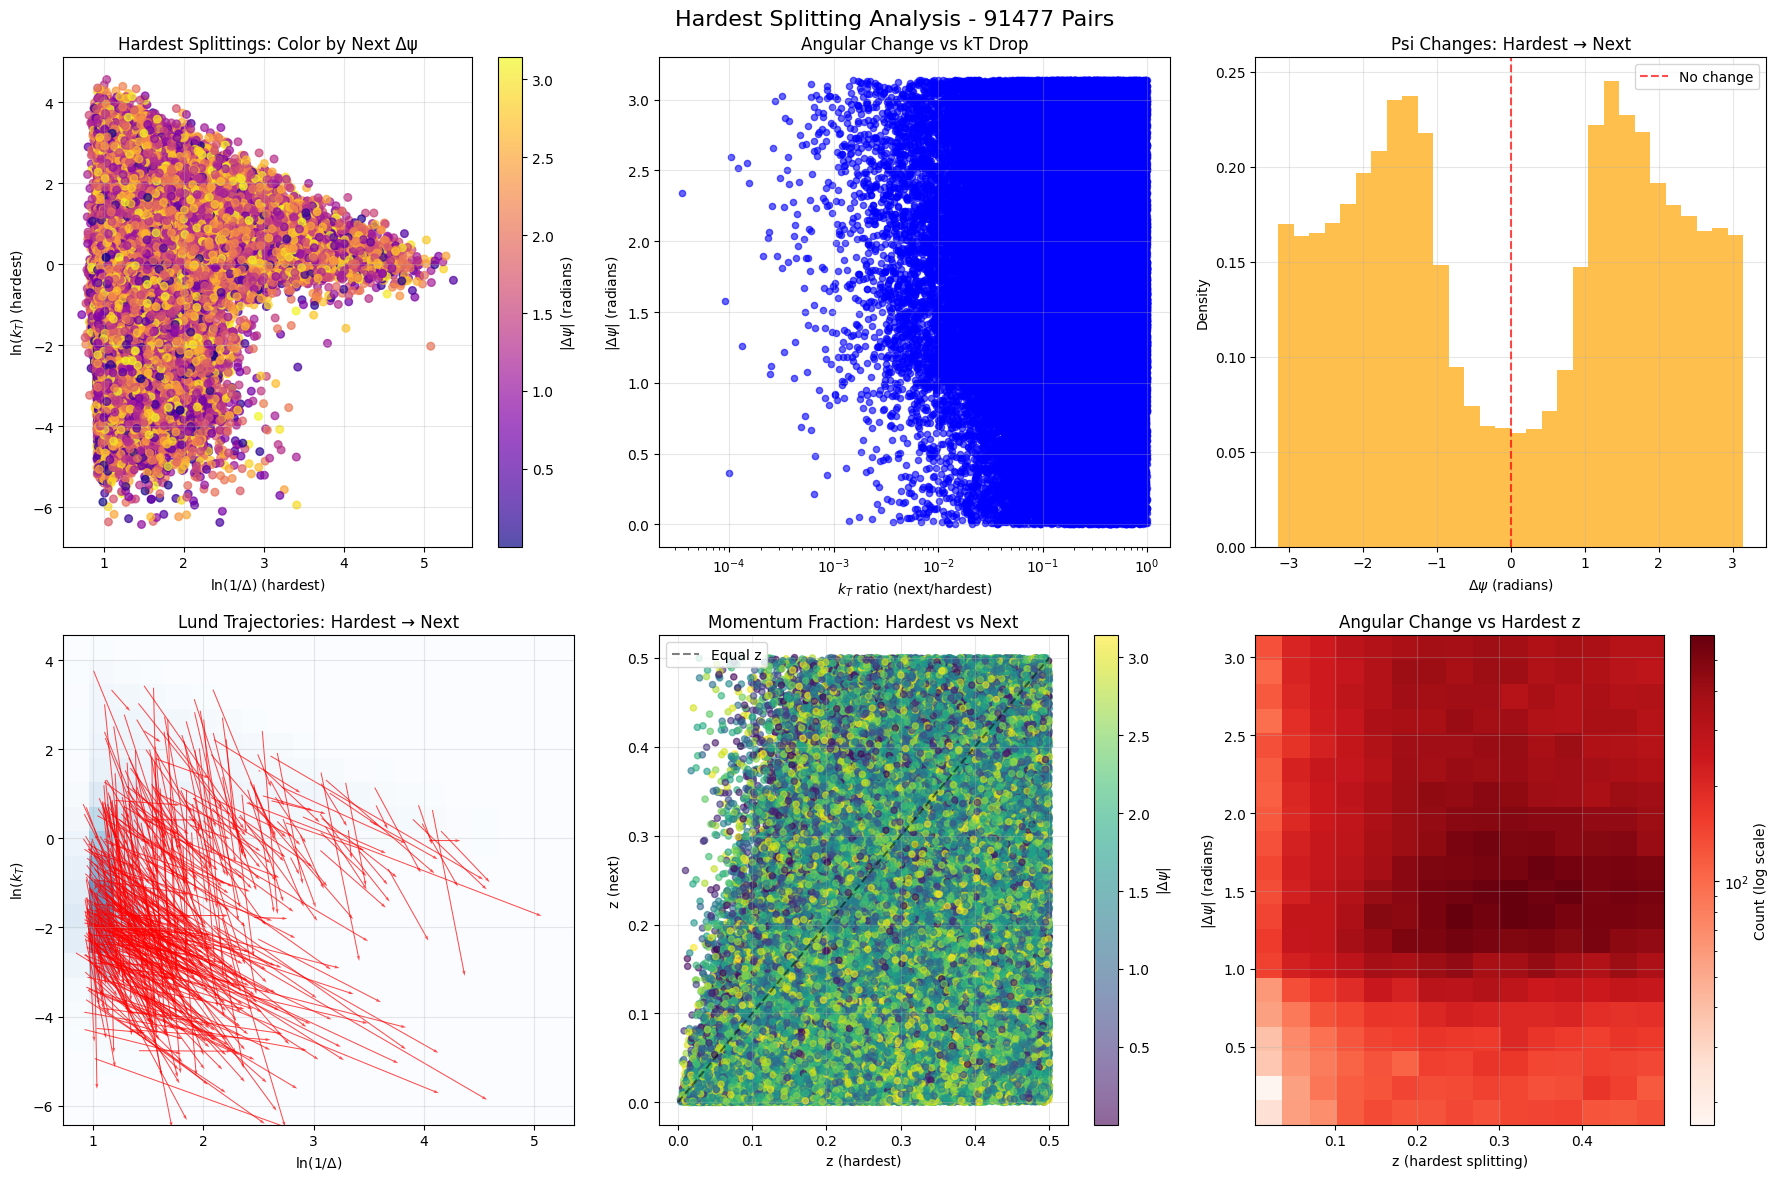

In [25]:
# Comprehensive visualization for hardest splitting pairs
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1) Hardest splittings in Lund plane, colored by next splitting's psi change
ax1 = axes[0, 0]
scatter = ax1.scatter(df_hardest['hardest_ln_inv_delta'], df_hardest['hardest_ln_kt'], 
                     c=np.abs(df_hardest['delta_psi']), 
                     cmap='plasma', s=30, alpha=0.7)
plt.colorbar(scatter, ax=ax1, label=r'$|\Delta\psi|$ (radians)')
ax1.set_xlabel(r'$\ln(1/\Delta)$ (hardest)')
ax1.set_ylabel(r'$\ln(k_T)$ (hardest)')
ax1.set_title('Hardest Splittings: Color by Next Δψ')
ax1.grid(True, alpha=0.3)

# 2) kT ratio vs psi change
ax2 = axes[0, 1]
ax2.scatter(df_hardest['kt_ratio'], np.abs(df_hardest['delta_psi']), 
           alpha=0.6, s=20, color='blue')
ax2.set_xlabel(r'$k_T$ ratio (next/hardest)')
ax2.set_ylabel(r'$|\Delta\psi|$ (radians)')
ax2.set_title('Angular Change vs kT Drop')
ax2.set_xscale('log')
ax2.grid(True, alpha=0.3)

# 3) Distribution of psi changes for hardest pairs only
ax3 = axes[0, 2]
ax3.hist(df_hardest['delta_psi'], bins=30, alpha=0.7, color='orange', density=True)
ax3.axvline(0, color='red', linestyle='--', alpha=0.7, label='No change')
ax3.set_xlabel(r'$\Delta\psi$ (radians)')
ax3.set_ylabel('Density')
ax3.set_title('Psi Changes: Hardest → Next')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4) Trajectory in Lund plane: hardest → next
ax4 = axes[1, 0]
# Background: density of hardest splittings
weights = np.ones_like(df_hardest['hardest_ln_inv_delta']) / len(df_jets)
ax4.hist2d(df_hardest['hardest_ln_inv_delta'], df_hardest['hardest_ln_kt'], 
           bins=[20, 20], cmap='Blues', alpha=0.6, weights=weights)

# Arrows showing trajectory from hardest to next
dx = df_hardest['next_ln_inv_delta'] - df_hardest['hardest_ln_inv_delta']
dy = df_hardest['next_ln_kt'] - df_hardest['hardest_ln_kt']

# Sample arrows to avoid overcrowding
n_arrows = min(500, len(df_hardest))
sample_idx = np.random.choice(len(df_hardest), n_arrows, replace=False)

ax4.quiver(df_hardest.iloc[sample_idx]['hardest_ln_inv_delta'], 
          df_hardest.iloc[sample_idx]['hardest_ln_kt'],
          dx.iloc[sample_idx], dy.iloc[sample_idx],
          angles='xy', scale_units='xy', scale=1, 
          width=0.002, color='red', alpha=0.7)

ax4.set_xlabel(r'$\ln(1/\Delta)$')
ax4.set_ylabel(r'$\ln(k_T)$')
ax4.set_title('Lund Trajectories: Hardest → Next')
ax4.grid(True, alpha=0.3)

# 5) z fraction comparison
ax5 = axes[1, 1]
ax5.scatter(df_hardest['hardest_z'], df_hardest['next_z'], 
           c=np.abs(df_hardest['delta_psi']), cmap='viridis', 
           alpha=0.6, s=20)
ax5.plot([0, 0.5], [0, 0.5], 'k--', alpha=0.5, label='Equal z')
plt.colorbar(ax5.collections[0], ax=ax5, label=r'$|\Delta\psi|$')
ax5.set_xlabel('z (hardest)')
ax5.set_ylabel('z (next)')
ax5.set_title('Momentum Fraction: Hardest vs Next')
ax5.legend()
ax5.grid(True, alpha=0.3)

# 6) Angular change vs hardest splitting properties
ax6 = axes[1, 2]
# Create 2D histogram: hardest z vs angular change
h = ax6.hist2d(df_hardest['hardest_z'], np.abs(df_hardest['delta_psi']), 
               bins=[15, 20], cmap='Reds', norm=mcolors.LogNorm())
plt.colorbar(h[3], ax=ax6, label='Count (log scale)')
ax6.set_xlabel('z (hardest splitting)')
ax6.set_ylabel(r'$|\Delta\psi|$ (radians)')
ax6.set_title('Angular Change vs Hardest z')
ax6.grid(True, alpha=0.3)

plt.suptitle(f'Hardest Splitting Analysis - {len(df_hardest)} Pairs', fontsize=16)
plt.tight_layout()
plt.show()

In [26]:
# Detailed analysis of angular patterns for hardest splitting pairs
print("=== HARDEST SPLITTING PAIR ANALYSIS ===\n")

# Basic statistics
print("Basic Statistics:")
print(f"  Total pairs analyzed: {len(df_hardest)}")
print(f"  Mean hardest kT: {df_hardest['hardest_kt'].mean():.3f}")
print(f"  Mean next kT: {df_hardest['next_kt'].mean():.3f}")
print(f"  Mean kT ratio (next/hardest): {df_hardest['kt_ratio'].mean():.3f}")
print(f"  Std kT ratio: {df_hardest['kt_ratio'].std():.3f}")
print()

# Angular change statistics
print("Angular Change Statistics:")
print(f"  Mean |Δψ|: {df_hardest['delta_psi'].abs().mean():.3f} radians ({np.degrees(df_hardest['delta_psi'].abs().mean()):.1f}°)")
print(f"  Std |Δψ|: {df_hardest['delta_psi'].abs().std():.3f} radians ({np.degrees(df_hardest['delta_psi'].abs().std()):.1f}°)")
print(f"  Max |Δψ|: {df_hardest['delta_psi'].abs().max():.3f} radians ({np.degrees(df_hardest['delta_psi'].abs().max()):.1f}°)")
print(f"  Fraction with |Δψ| > π/2: {(df_hardest['delta_psi'].abs() > np.pi/2).mean():.3f}")
print(f"  Fraction with |Δψ| > π/4: {(df_hardest['delta_psi'].abs() > np.pi/4).mean():.3f}")
print()

# Correlations
print("Correlation Analysis (for hardest pairs):")
corr_vars = ['delta_psi', 'kt_ratio', 'hardest_ln_kt', 'hardest_z', 'next_z']
correlations = df_hardest[corr_vars].corr()['delta_psi'].abs().sort_values(ascending=False)
for var, corr in correlations.items():
    if var != 'delta_psi':
        print(f"  |Δψ| vs {var}: {corr:.3f}")
print()

# Binned analysis by kT ratio
print("Angular Change vs kT Ratio (binned analysis):")
kt_ratio_bins = [0, 0.1, 0.2, 0.3, 0.5, 1.0]
for i in range(len(kt_ratio_bins)-1):
    mask = (df_hardest['kt_ratio'] >= kt_ratio_bins[i]) & (df_hardest['kt_ratio'] < kt_ratio_bins[i+1])
    if mask.sum() > 0:
        mean_psi = df_hardest[mask]['delta_psi'].abs().mean()
        count = mask.sum()
        print(f"  kT ratio [{kt_ratio_bins[i]:.1f}, {kt_ratio_bins[i+1]:.1f}): "
              f"<|Δψ|> = {mean_psi:.3f} rad ({np.degrees(mean_psi):.1f}°), N = {count}")
print()

# Examples of specific cases
print("Examples of extreme cases:")
# Highest angular change
max_psi_idx = df_hardest['delta_psi'].abs().idxmax()
print(f"  Largest |Δψ|: {df_hardest.loc[max_psi_idx, 'delta_psi']:.3f} rad "
      f"({np.degrees(df_hardest.loc[max_psi_idx, 'delta_psi']):.1f}°)")
print(f"    kT ratio: {df_hardest.loc[max_psi_idx, 'kt_ratio']:.3f}")
print(f"    Hardest kT: {df_hardest.loc[max_psi_idx, 'hardest_kt']:.3f}")

# Smallest angular change  
min_psi_idx = df_hardest['delta_psi'].abs().idxmin()
print(f"  Smallest |Δψ|: {df_hardest.loc[min_psi_idx, 'delta_psi']:.3f} rad "
      f"({np.degrees(df_hardest.loc[min_psi_idx, 'delta_psi']):.1f}°)")
print(f"    kT ratio: {df_hardest.loc[min_psi_idx, 'kt_ratio']:.3f}")
print(f"    Hardest kT: {df_hardest.loc[min_psi_idx, 'hardest_kt']:.3f}")

# Compare with all consecutive pairs (from previous analysis)
if 'df_psi' in locals():
    print(f"\nComparison with all consecutive pairs:")
    print(f"  All pairs mean |Δψ|: {df_psi['delta_psi'].abs().mean():.3f} rad")
    print(f"  Hardest pairs mean |Δψ|: {df_hardest['delta_psi'].abs().mean():.3f} rad")
    print(f"  Ratio (hardest/all): {df_hardest['delta_psi'].abs().mean() / df_psi['delta_psi'].abs().mean():.2f}")

=== HARDEST SPLITTING PAIR ANALYSIS ===

Basic Statistics:
  Total pairs analyzed: 91477
  Mean hardest kT: 2.055
  Mean next kT: 0.345
  Mean kT ratio (next/hardest): 0.318
  Std kT ratio: 0.252

Angular Change Statistics:
  Mean |Δψ|: 1.760 radians (100.8°)
  Std |Δψ|: 0.776 radians (44.5°)
  Max |Δψ|: 3.142 radians (180.0°)
  Fraction with |Δψ| > π/2: 0.574
  Fraction with |Δψ| > π/4: 0.890

Correlation Analysis (for hardest pairs):
  |Δψ| vs hardest_z: 0.004
  |Δψ| vs hardest_ln_kt: 0.001
  |Δψ| vs kt_ratio: 0.001
  |Δψ| vs next_z: 0.001

Angular Change vs kT Ratio (binned analysis):
  kT ratio [0.0, 0.1): <|Δψ|> = 1.848 rad (105.9°), N = 20902
  kT ratio [0.1, 0.2): <|Δψ|> = 1.773 rad (101.6°), N = 16979
  kT ratio [0.2, 0.3): <|Δψ|> = 1.742 rad (99.8°), N = 13844
  kT ratio [0.3, 0.5): <|Δψ|> = 1.731 rad (99.2°), N = 18958
  kT ratio [0.5, 1.0): <|Δψ|> = 1.700 rad (97.4°), N = 20794

Examples of extreme cases:
  Largest |Δψ|: 3.142 rad (180.0°)
    kT ratio: 0.596
    Hardest kT: